# **Simulation de méta-communautés à 3 espèces**

In [1]:
# Importation des librairies
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocess import Pool
import pickle

In [22]:
N_ITER_SITE = 40  # Nombre de planning différents
NITER = 30  # Nombre d'itérations par planning
T = 200  # Nombre de pas de temps
X = 250  # Nombre de sites
E = 8  # Nombre d'espèces
H = 3  # Nombre de ressources
P = H*1.9

PALL = 0.05  # probabilité d'allumage d'un site éteint au temps t
PEXT = 0.05  # probilité d'extinction d'un site allumé au temps t

RES_X = np.array([0]*math.ceil(X/(P))+[1]*int(((P-1)/(H-1))*X/(P))+[2]*int(((P-1)/(H-1))*X/(P)))

In [23]:
# Variables liées aux espèces
# Génération des effectifs initiaux
N0X = 1

R = 2  # Taux de croissance maximal
MU = 0.1  # Taux de mortalité
D = 0.1  # Taux de dispersion
C = 0.5  # Taux de mortalité lors de la dispersion

# Variables liées à l'exploitation des ressources (E = 3, H = 2)
K0 = 200
SP = 0
GE = 0.8

csts = [N0X,R,MU,D,C,GE,SP,K0]

In [24]:
stock_cov = np.array([[[[[0]*X]*T]*NITER]*N_ITER_SITE]*5)

In [12]:
def alea(v) :
    """ Fonction de sélection aléatoire des sites disponibles au temps t+1
    
    Paramètres
    ----------
    v : list
        Statut des sites au temps t (0 ou 1)
    
    Return
    ------
    list
        Statut des sites au temps t+1 (0 ou 1)
    
    """
    u = list.copy(v)

    all_t = [i for i in range(len(v)) if v[i]==1]
    ext_t = [i for i in range(len(v)) if v[i]==0]

    all_tplus = random.sample(ext_t, np.random.binomial(len(ext_t), PALL))
    ext_tplus = random.sample(all_t, np.random.binomial(len(all_t), PEXT))

    for i in all_tplus :
        u[i] = 1
    for i in ext_tplus :
        u[i] = 0
    
    return u

def interaction(n, a, i) :
    """ Fonction d'interaction d'une espèce i parmi R espèces

    Cette fonction calcule le membre 'somme(alpha_{ij}*N_j)' de l'équation de compétition de Lotka-Volterra pour l'espèce i

    Paramètres
    ----------
    n : liste de taille R
        Effectifs des R espèces
    a : array de taille R*R
        Matrice des coefficients d'interaction entre les R espèces
    i : int
        Identifiant de l'espèce d'intérêt
    
    Return
    ------
    float
        somme(alpha_{ij}*N_j)
    
    """
    alpha = a[i]  # Sélection des coefficients d'interaction de l'espèce i avec les R espèces
    inter = n*alpha  # alpha_{ij}*N_j
    return sum(inter)
def reproduction(n, a, i, x, c) :
    """ Fonction de croissance d'une espèce en compétition avec d'autres sur une génération

    Cette fonction calcule l'effectif après reproduction d'une population suivant une croissance logistique, en compétition
    de Lotka-Volterra avec d'autres espèces

    Paramètres
    ----------
    n : list
        Effectif des espèces au temps t
    i : int
        Identifiant de l'espèce d'intérêt
    
    Return
    ------
    int
        Effectif de la population après reproduction et mortalité au temps t
    
    """
    n = list(n[x])
    if c[5][x][i]==0 :
        return 0
    else :
        return int((n[i] + n[i]*c[1][i]*(1-(interaction(n, a, i)/c[5][x][i])))*(1-c[2][i]))
def dynamique_intra(n, x, a, c) :
    """ Fonction de dynamique de R espèces sur une génération à l'intérieur d'un site x

    Cette fonction calcule l'effectif à la génération suivante pour R espèces suivant une croissance logistique
    sur un site x, avec de la dispersion entre les X sites

    Paramètres
    ----------
    n : int
        Effectif de la population au temps t au site x
    x : int
        Identifiant du site x
    
    Return
    ------
    array de taille 2
        Effectif de chaque espèce après reproduction et dispersion, et nombre de migrants issus du site x
    
    """
    nb = np.array([reproduction(n, a, i, x, c) for i in range(E)])  # Effectif après reproduction
    nb[nb < 0] = 0
    d = np.array([int(c[3][i]*nb[i]) for i in range(E)])

    return [nb-d,d]
def effectif(n) : 
    """ Fonction de tri des effectif des espèces

    Cette fonction traite les données issues de la fonction dynamique_intra et regroupe d'une part les effectifs de 
    chaque espèce dans chaque site dans une matrice R*X, et d'autre part les pools de migrant de chaque espèce dans une liste

    Paramètres
    ----------
    n : array de taille X*R*2
        Effectif de chaque espèces et migrants issus de chaque site
    
    Return
    ------
    list(array, list)
        Liste avec la matrice des effectifs de chaque espèce dans chaque site, et la liste des pools de migrant de chaque espèce
    
    """
    site = np.array([n[x][0] for x in range(X)])
    pool = np.array([n[x][1] for x in range(X)])
    pool = list(np.sum(pool,0))
    return list([site, pool])
def migration(m, i, c) :
    """ Fonction de migration d'une espèce i entre X sites

    Cette fonction répartit selon une distribution multinomiale un pool de migrants entre X sites

    Paramètres
    ----------
    m : int
        Pool de migrants
    
    Return
    ------
    list
        Effectifs de migrants dans chacun des sites
    
    """
    m = m[i] - int(m[i]*c[4][i])  # Application du taux de mortalité pendant la dispersion
    return np.random.multinomial(m, [1/X]*X)
def dynamique_inter(n, a, c) :
    """ Fonction de dynamique d'une population sur une génération entre plusieurs sites

    Cette fonction calcule l'effectif à la génération suivante d'une population suivant une croissance logistique
    sur plusieurs sites, avec de la dispersion entre les sites

    Paramètres
    ----------
    n : list
        Effectif de la population sur chaque site au temps t
    
    Return
    ------
    array de taille 2
        Effectif de la population après reproduction et dispersion dans chaque site, et nombre de migrants de chaque espèce
    
    """
    intra = np.array([dynamique_intra(n, x, a, c) for x in range(X)])  # Calcul des effectifs et des migrants de chaque site
    eff = effectif(intra)  # Tri des effectifs
    d = eff[1]  # Sélection des pools de migrants
    mig = np.array([migration(d,i,c) for i in range(E)]).T  # Répartition des migrants entre les sites
    n_plus = eff[0]+ mig  # Effectifs de chaque espèce dans chaque site à la fin de la génération
    return [n_plus, d]

def iterations(value):
    cst = value[0]
    dispo = value[1]

    a = np.array([[value[2]]*E]*E)
    for w in range(E):
        a[w,w] = 1.0

    stock_n = np.array([[[[[0]*E]*X]*T]*NITER]*N_ITER_SITE)

    for i in range(N_ITER_SITE) :
        for j in range(NITER) :
            stock_n[i][j][0] = np.array([[csts[0]*dispo[i][0][x]]*E for x in range(X)])
            for t in range(T-1) :
                stock_n[i][j][t+1] = dynamique_inter(stock_n[i][j][t],a,cst)[0]*np.array([stock_cov[0][i][j][t+1]]*E).T.reshape(X,E)
    return(stock_n)

In [25]:
liste_dispo = []
liste_age = []
for s in range(N_ITER_SITE) :
    states = [random.randint(0,1) for i in range(X)]  # état initial des sites
    dispo = [states]
    age_site = [states]
    for gen in range(T-1) :
        state = alea(dispo[gen])
        while np.mean(state) < 0.45 or np.mean(state) > 0.55 :
            state = alea(dispo[gen])
        age = [(age_site[gen][x]+state[x])*state[x] for x in range(X)]
        dispo = dispo + [state]
        age_site = age_site + [age]
    liste_dispo = liste_dispo + [dispo]
    liste_age = liste_age + [age_site]

In [26]:
for i in range(N_ITER_SITE) :
    for j in range(NITER) :
        for gen in range(T) :
            stock_cov[0][i][j][gen] = liste_dispo[i][gen]
            stock_cov[1][i][j][gen] = RES_X
            stock_cov[2][i][j][gen] = np.array([gen]*X)
            stock_cov[3][i][j][gen] = np.linspace(1,X,X)
            stock_cov[4][i][j][gen] = liste_age[i][gen]


In [27]:
# 1 ressources : test effets de priorité 3 espèces identiques

n0 = np.array([[csts[0]]*E]*X)
r = [csts[1]]*E  # Taux de croissance maximal
mu = [csts[2]]*E  # Taux de mortalité
d = [csts[3]]*E  # Taux de dispersion
c = [csts[4]]*E  # Taux de mortalité lors de la dispersion

# Variables liées à l'exploitation des ressources (E = 3, H = 2)
#res_exp = np.array([1]*E)
res_exp = np.array([[csts[5],csts[5],csts[5],csts[5],csts[6],csts[6],csts[6],csts[6]],
                    [csts[5],csts[5],csts[5],csts[5],1,1,1,csts[6]],
                    [csts[5],csts[5],csts[5],csts[5],csts[6],csts[6],csts[6],1]])
k_res = np.array([[csts[7]]*E]*H) * res_exp  # Capacité d'accueil des ressources
#k = np.array([k_res[0]]*X)  # Capacité d'accueil du site pour chaque espèce
k = [k_res[RES_X[x]] for x in range(X)]
const = [n0,r,mu,d,c,k]

values = [const,liste_dispo,2],[const,liste_dispo,4]

In [28]:
if __name__ == '__main__':
    with Pool(2) as p:
        results = p.map(iterations, values)

In [33]:
filehandler = open("multiple8sp.npy","wb")
pickle.dump(results,filehandler)
filehandler.close()

In [7]:
file = open("multipleR.npy",'rb')
object_file = pickle.load(file)
file.close()
results = object_file

In [29]:
res1 = np.array([[[[[[0]*E]*math.ceil(X/P)]*T]*NITER]*N_ITER_SITE]*len(results))
res2 = np.array([[[[[[0]*E]*int(((P-1)/(H-1))*X/P)]*T]*NITER]*N_ITER_SITE]*len(results))
res3 = np.array([[[[[[0]*E]*int(((P-1)/(H-1))*X/P)]*T]*NITER]*N_ITER_SITE]*len(results))

for r in range(len(results)):
    for i in range(N_ITER_SITE):
        for j in range(NITER):
            for t in range(T):
                res1[r][i][j][t] = [results[r][i][j][t][x] for x in range(X) if RES_X[x]==0]
                res2[r][i][j][t] = [results[r][i][j][t][x] for x in range(X) if RES_X[x]==1]
                res3[r][i][j][t] = [results[r][i][j][t][x] for x in range(X) if RES_X[x]==2]

In [30]:
mean0 = []
mean0 = mean0 + [np.mean(np.mean(np.sum(results[0], axis=3),axis=1),axis=0).T]
mean0 = mean0 + [np.mean(np.mean(np.sum(res1[0], axis=3),axis=1),axis=0).T]
mean0 = mean0 + [np.mean(np.mean(np.sum(res2[0], axis=3),axis=1),axis=0).T]
mean0 = mean0 + [np.mean(np.mean(np.sum(res3[0], axis=3),axis=1),axis=0).T]

In [31]:
mean1 = []
mean1 = mean1 + [np.mean(np.mean(np.sum(results[1], axis=3),axis=1),axis=0).T]
mean1 = mean1 + [np.mean(np.mean(np.sum(res1[1], axis=3),axis=1),axis=0).T]
mean1 = mean1 + [np.mean(np.mean(np.sum(res2[1], axis=3),axis=1),axis=0).T]
mean1 = mean1 + [np.mean(np.mean(np.sum(res3[1], axis=3),axis=1),axis=0).T]

In [20]:
mean2 = []
mean2 = mean2 + [np.mean(np.mean(np.sum(results[2], axis=3),axis=1),axis=0).T]
mean2 = mean2 + [np.mean(np.mean(np.sum(res1[2], axis=3),axis=1),axis=0).T]
mean2 = mean2 + [np.mean(np.mean(np.sum(res2[2], axis=3),axis=1),axis=0).T]
mean2 = mean2 + [np.mean(np.mean(np.sum(res3[2], axis=3),axis=1),axis=0).T]

IndexError: list index out of range

In [10]:
mean3 = []
mean3 = mean3 + [np.mean(np.mean(np.sum(results[3], axis=3),axis=1),axis=0).T]
mean3 = mean3 + [np.mean(np.mean(np.sum(res1[3], axis=3),axis=1),axis=0).T]
mean3 = mean3 + [np.mean(np.mean(np.sum(res2[3], axis=3),axis=1),axis=0).T]
mean3 = mean3 + [np.mean(np.mean(np.sum(res3[3], axis=3),axis=1),axis=0).T]

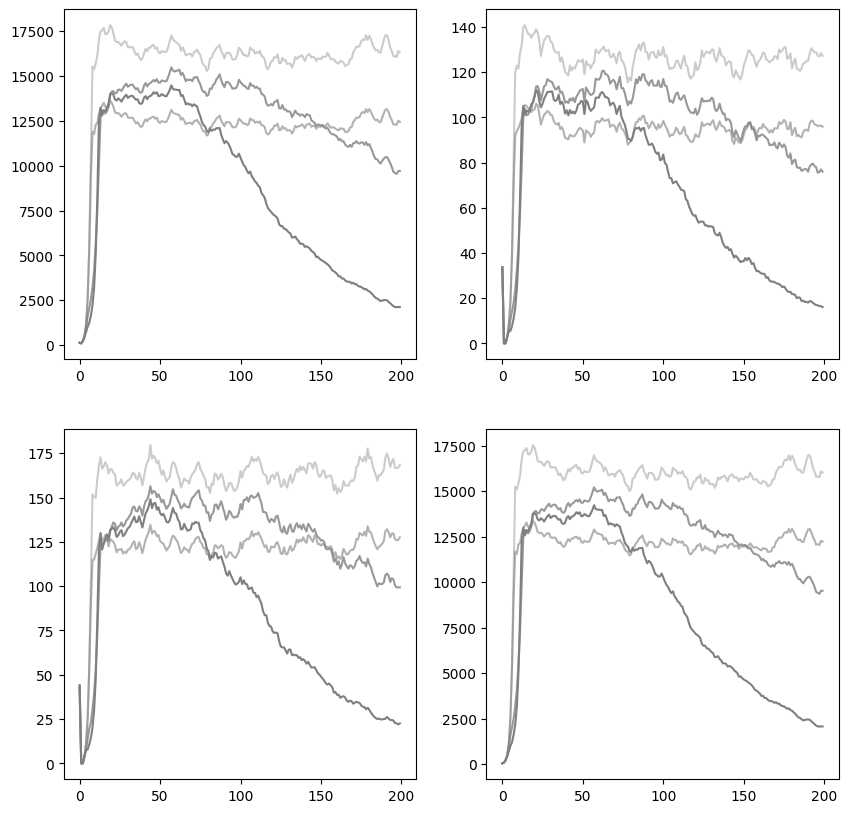

In [65]:
palette = sns.color_palette(None, H+E)

fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig1.set_size_inches(10,10)

i=7

ax1.plot(mean0[0][i], color = palette[i], alpha = 0.4)
ax1.plot(mean1[0][i], color = palette[i], alpha = 0.6)
ax1.plot(mean2[0][i], color = palette[i], alpha = 0.8)
ax1.plot(mean3[0][i], color = palette[i], alpha = 1)

ax2.plot(mean0[1][i], color = palette[i], alpha = 0.4)
ax2.plot(mean1[1][i], color = palette[i], alpha = 0.6)
ax2.plot(mean2[1][i], color = palette[i], alpha = 0.8)
ax2.plot(mean3[1][i], color = palette[i], alpha = 1)

ax3.plot(mean0[2][i], color = palette[i], alpha = 0.4)
ax3.plot(mean1[2][i], color = palette[i], alpha = 0.6)
ax3.plot(mean2[2][i], color = palette[i], alpha = 0.8)
ax3.plot(mean3[2][i], color = palette[i], alpha = 1)

ax4.plot(mean0[3][i], color = palette[i], alpha = 0.4)
ax4.plot(mean1[3][i], color = palette[i], alpha = 0.6)
ax4.plot(mean2[3][i], color = palette[i], alpha = 0.8)
ax4.plot(mean3[3][i], color = palette[i], alpha = 1)


plt.show()

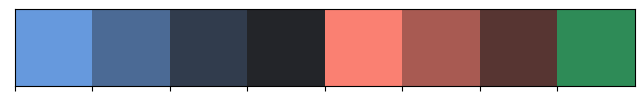

In [77]:


# Generate the seaborn palette
palette = sns.dark_palette("#69d", reverse=True)
palette2 = sns.dark_palette("salmon", reverse=True)
palette3 = sns.dark_palette("seagreen", reverse=True)

pal_fin = (palette[0], palette[2],palette[4],palette[5],palette2[0], palette2[2],palette2[4],palette3[0])

# Display the palette
sns.palplot(pal_fin)
plt.show()

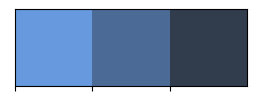

In [53]:
sns.palplot((palette[0],palette[2],palette[4]))

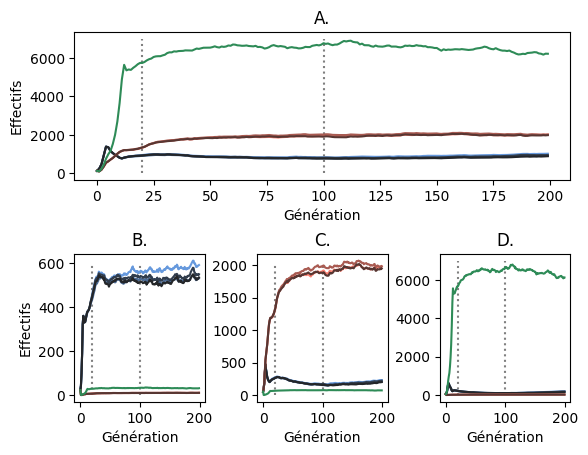

In [81]:
import matplotlib.gridspec as gridspec
#palette = sns.color_palette(None, H+E)
palette = pal_fin

#fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
AX = gridspec.GridSpec(2,3)
AX.update(wspace = 0.4, hspace = 0.5)
ax1  = plt.subplot(AX[0,:])
ax2 = plt.subplot(AX[1,0])
ax3 = plt.subplot(AX[1,1])
ax4 = plt.subplot(AX[1,2])

ax1.set_xlabel("Génération")
ax2.set_xlabel("Génération")
ax3.set_xlabel("Génération")
ax4.set_xlabel("Génération")
ax1.set_ylabel("Effectifs")
ax2.set_ylabel("Effectifs")
ax1.set_title("A.")
ax2.set_title("B.")
ax3.set_title("C.")
ax4.set_title("D.")
#fig1.set_size_inches(10,10)
ax1.plot([20,20],[0,7000], 'grey', linestyle = "dotted")
ax1.plot([100,100],[0,7000], 'grey', linestyle = "dotted")
ax2.plot([20,20],[0,600], 'grey', linestyle = "dotted")
ax2.plot([100,100],[0,600], 'grey', linestyle = "dotted")
ax3.plot([20,20],[0,2000], 'grey', linestyle = "dotted")
ax3.plot([100,100],[0,2000], 'grey', linestyle = "dotted")
ax4.plot([20,20],[0,7000], 'grey', linestyle = "dotted")
ax4.plot([100,100],[0,7000], 'grey', linestyle = "dotted")

for i in range(E):
    #ax1.plot(mean0[0][i], color = palette[i], alpha = 0.4)
    #ax1.plot(mean1[0][i], color = palette[i], alpha = 0.6)
    #ax1.plot(mean2[0][i], color = palette[i], alpha = 0.8)
    ax1.plot(mean0[0][i], color = palette[i], alpha = 1)

    #ax2.plot(mean0[1][i], color = palette[i], alpha = 0.4)
    #ax2.plot(mean1[1][i], color = palette[i], alpha = 0.6)
    #ax2.plot(mean2[1][i], color = palette[i], alpha = 0.8)
    ax2.plot(mean0[1][i], color = palette[i], alpha = 1)

    #ax3.plot(mean0[2][i], color = palette[i], alpha = 0.4)
    #ax3.plot(mean1[2][i], color = palette[i], alpha = 0.6)
    #ax3.plot(mean2[2][i], color = palette[i], alpha = 0.8)
    ax3.plot(mean0[2][i], color = palette[i], alpha = 1)

    #ax4.plot(mean0[3][i], color = palette[i], alpha = 0.4)
    #ax4.plot(mean1[3][i], color = palette[i], alpha = 0.6)
    #ax4.plot(mean2[3][i], color = palette[i], alpha = 0.8)
    ax4.plot(mean0[3][i], color = palette[i], alpha = 1)


plt.show()

In [18]:
a = np.array([[0,1,2],[2,4,7]])
np.tile(a,(3,1))

array([[0, 1, 2],
       [2, 4, 7],
       [0, 1, 2],
       [2, 4, 7],
       [0, 1, 2],
       [2, 4, 7]])

In [33]:
results_n = results[0].reshape(X*T*NITER*N_ITER_SITE,E)
results_cov = np.array([[[[np.array([stock_cov[0][i][j][t][x],stock_cov[4][i][j][t][x],stock_cov[1][i][j][t][x],t,x,j,i]) 
                         for x in range(X)] for t in range(T)]for j in range(NITER)]for i in range(N_ITER_SITE)]).reshape(X*T*NITER*N_ITER_SITE,7)


In [37]:
np.savetxt("abundance.csv", results_n, delimiter=",")
np.savetxt("covariable.csv", results_cov, delimiter=",")

In [34]:
stock_d = np.array([[[[0.0]*T]*NITER]*N_ITER_SITE]*len(results))
stock_d_res1 = np.array([[[[0.0]*T]*NITER]*N_ITER_SITE]*len(results))
stock_d_res2 = np.array([[[[0.0]*T]*NITER]*N_ITER_SITE]*len(results))
stock_d_res3 = np.array([[[[0.0]*T]*NITER]*N_ITER_SITE]*len(results))

In [35]:
for v in range(len(results)) :
    for i in range(N_ITER_SITE):
        for j in range(NITER):
            for t in range(T):
                abun = np.sum(results[v][i][j][t], axis=0)
                tot = np.sum(abun)
                p_tot = [np.divide(abun[i],tot) for i in range(E)]

                h = 0
                for e in range(E) :
                    if p_tot[e]==0 :
                        h = h
                    else :
                        h = h - p_tot[e]*math.log(p_tot[e])
                stock_d[v][i][j][t] = math.exp(h)

for v in range(len(results)) :
    for i in range(N_ITER_SITE):
        for j in range(NITER):
            for t in range(T):
                abun = np.sum(res1[v][i][j][t], axis=0)
                tot = np.sum(abun)
                p_tot = [np.divide(abun[i],tot) for i in range(E)]

                h = 0
                for e in range(E) :
                    if p_tot[e]==0 :
                        h = h
                    else :
                        h = h - p_tot[e]*math.log(p_tot[e])
                stock_d_res1[v][i][j][t] = math.exp(h)

for v in range(len(results)) :
    for i in range(N_ITER_SITE):
        for j in range(NITER):
            for t in range(T):
                abun = np.sum(res2[v][i][j][t], axis=0)
                tot = np.sum(abun)
                p_tot = [np.divide(abun[i],tot) for i in range(E)]

                h = 0
                for e in range(E) :
                    if p_tot[e]==0 :
                        h = h
                    else :
                        h = h - p_tot[e]*math.log(p_tot[e])
                stock_d_res2[v][i][j][t] = math.exp(h)

for v in range(len(results)) :
    for i in range(N_ITER_SITE):
        for j in range(NITER):
            for t in range(T):
                abun = np.sum(res3[v][i][j][t], axis=0)
                tot = np.sum(abun)
                p_tot = [np.divide(abun[i],tot) for i in range(E)]

                h = 0
                for e in range(E) :
                    if p_tot[e]==0 :
                        h = h
                    else :
                        h = h - p_tot[e]*math.log(p_tot[e])
                stock_d_res3[v][i][j][t] = math.exp(h)

In [36]:
mean_d = np.mean(np.mean(stock_d, axis = 2),axis = 1)
mean_d_res1 = np.mean(np.mean(stock_d_res1, axis = 2),axis = 1)
mean_d_res2 = np.mean(np.mean(stock_d_res2, axis = 2),axis = 1)
mean_d_res3 = np.mean(np.mean(stock_d_res3, axis = 2),axis = 1)

IndexError: index 2 is out of bounds for axis 0 with size 2

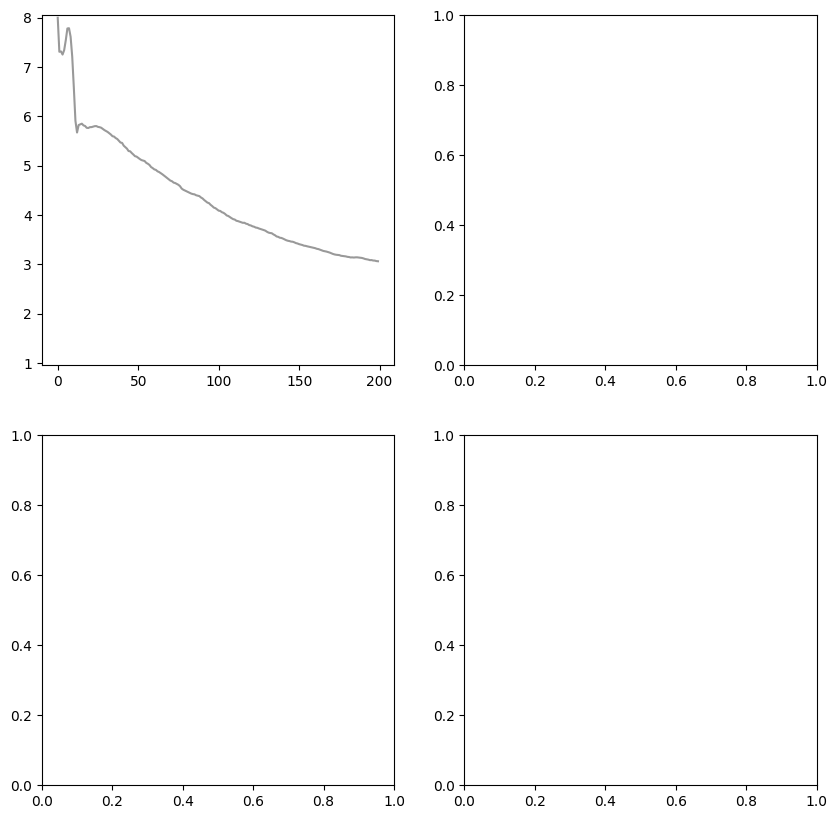

In [38]:
fig2, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig2.set_size_inches(10,10)
ax1.set_ylim(0.95,E+0.05)
ax1.plot(mean_d[0], color = 'black', alpha = 0.4)
#ax1.plot(mean_d[1], color = 'black', alpha = 0.6)
ax1.plot(mean_d[2], color = 'black', alpha = 0.8)
#ax1.plot(mean_d[3], color = 'black', alpha = 1)

ax2.set_ylim(0.95,E+0.05)
ax2.plot(mean_d_res1[0], color = 'black', alpha = 0.4)
#ax2.plot(mean_d_res1[1], color = 'black', alpha = 0.6)
ax2.plot(mean_d_res1[2], color = 'black', alpha = 0.8)
#ax2.plot(mean_d_res1[3], color = 'black', alpha = 1)

ax3.set_ylim(0.95,E+0.05)
ax3.plot(mean_d_res2[0], color = 'black', alpha = 0.4)
#ax3.plot(mean_d_res2[1], color = 'black', alpha = 0.6)
ax3.plot(mean_d_res2[2], color = 'black', alpha = 0.8)
#ax3.plot(mean_d_res2[3], color = 'black', alpha = 1)

ax4.set_ylim(0.95,E+0.05)
ax4.plot(mean_d_res3[0], color = 'black', alpha = 0.4)
#ax4.plot(mean_d_res3[1], color = 'black', alpha = 0.6)
ax4.plot(mean_d_res3[2], color = 'black', alpha = 0.8)
#ax4.plot(mean_d_res3[3], color = 'black', alpha = 1)

plt.show()

In [16]:
len(np.mean(results[2][0][7],axis=1).T[0])

200

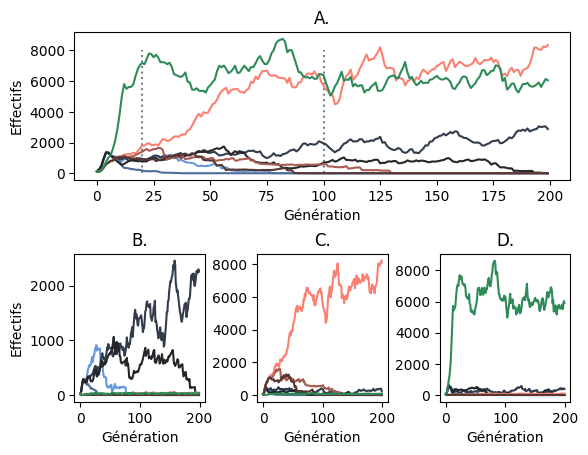

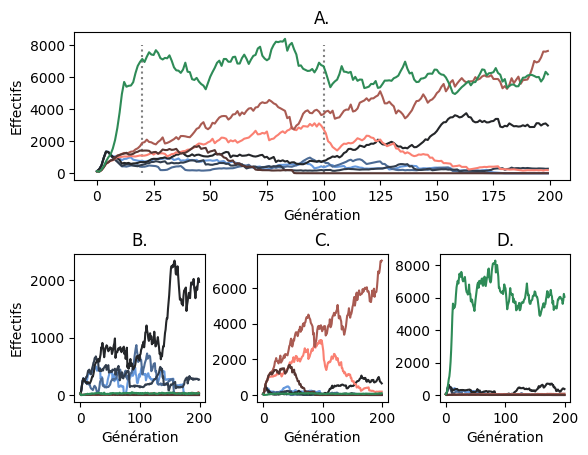

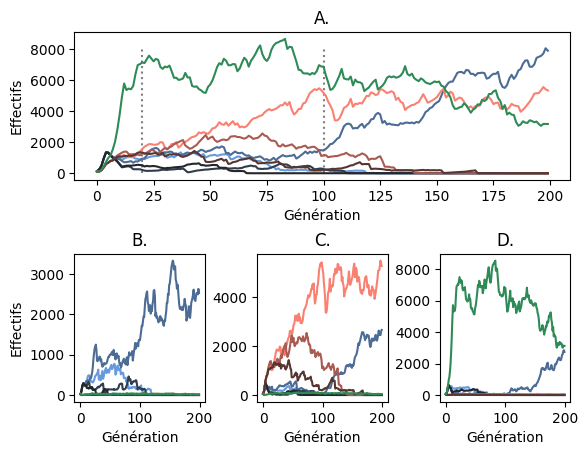

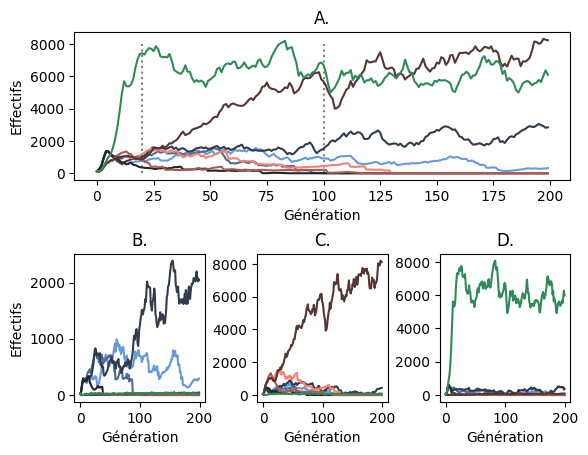

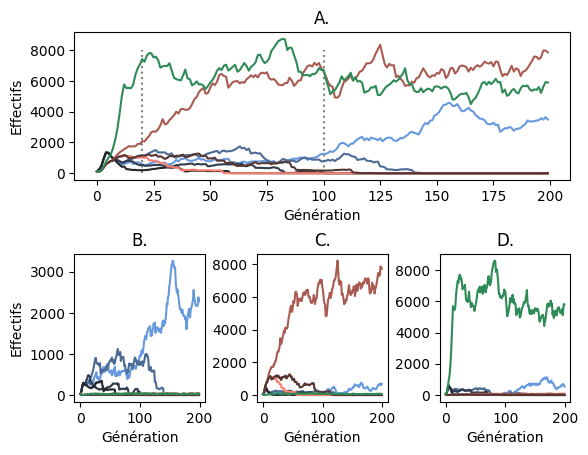

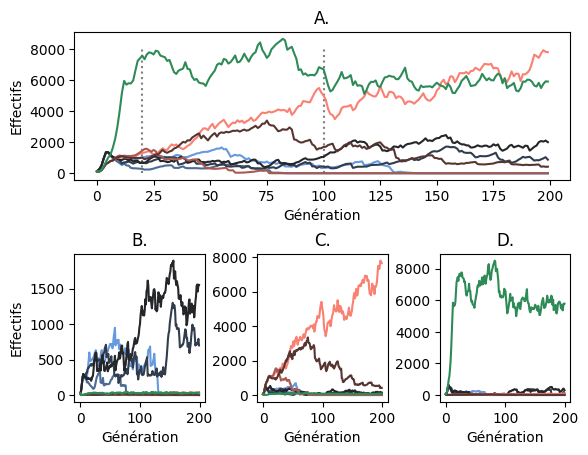

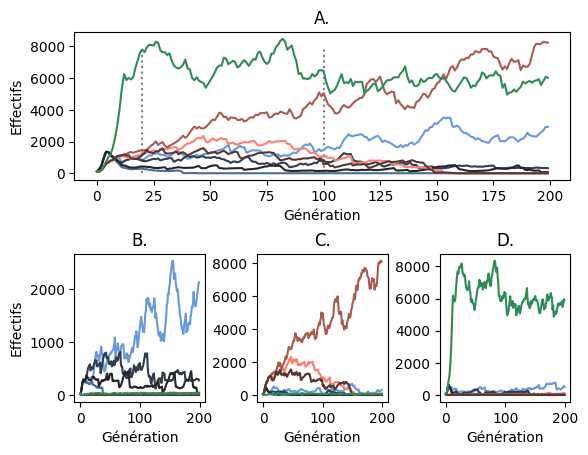

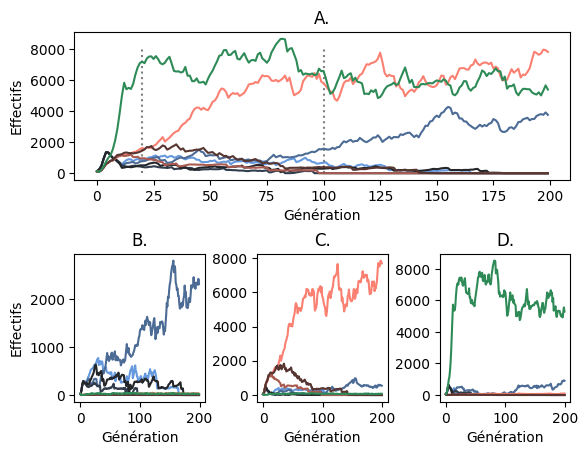

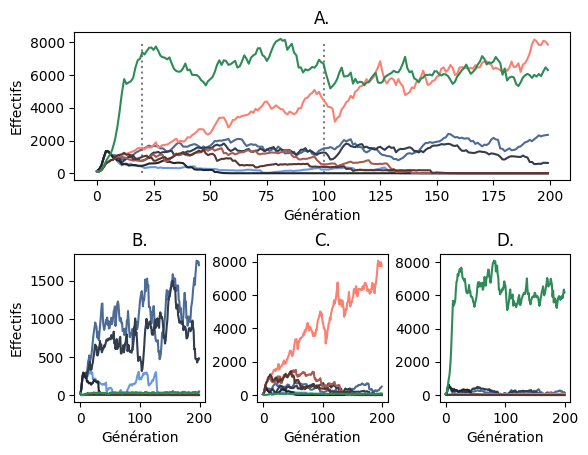

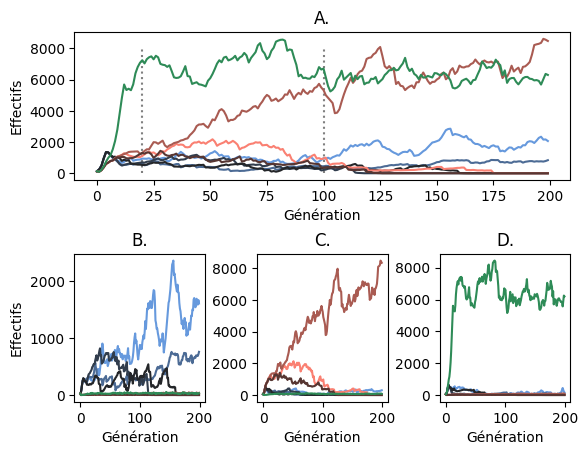

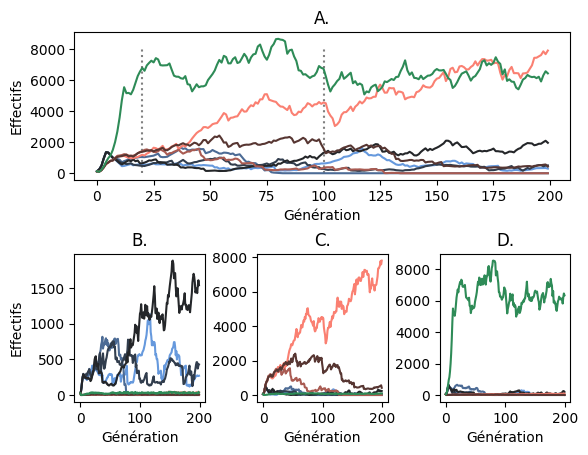

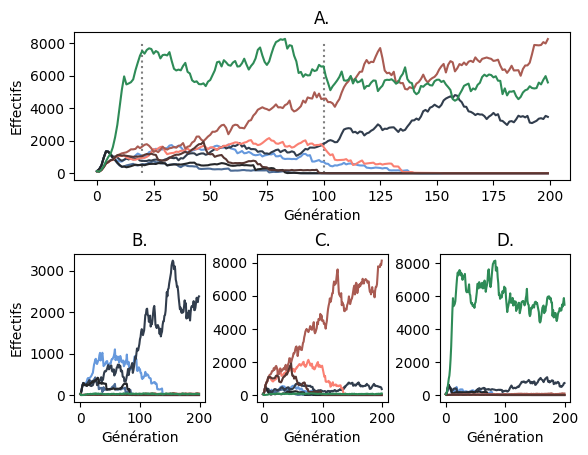

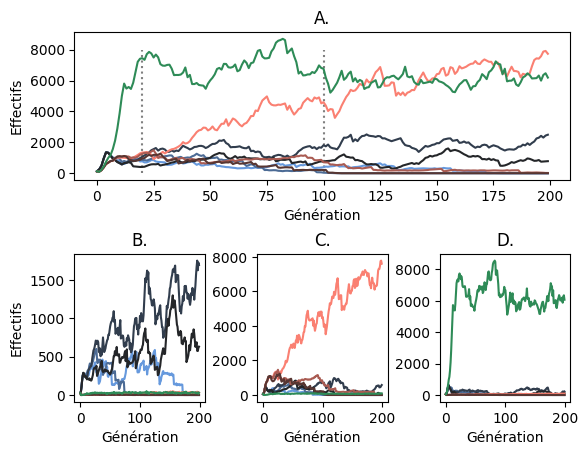

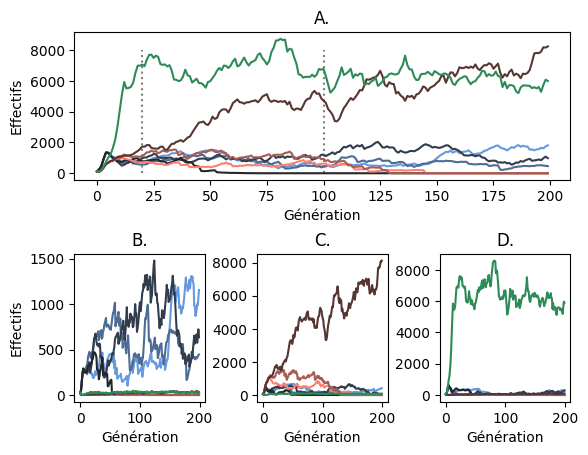

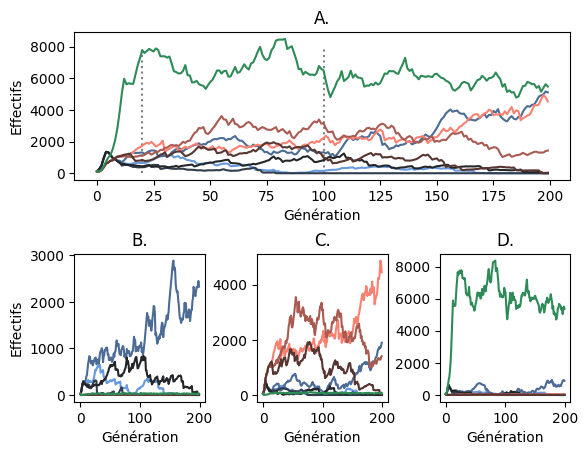

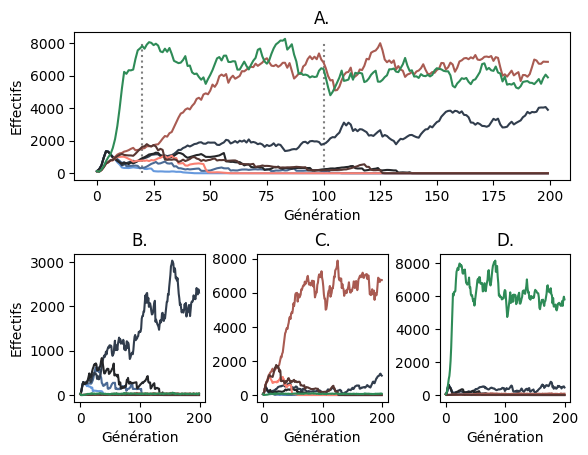

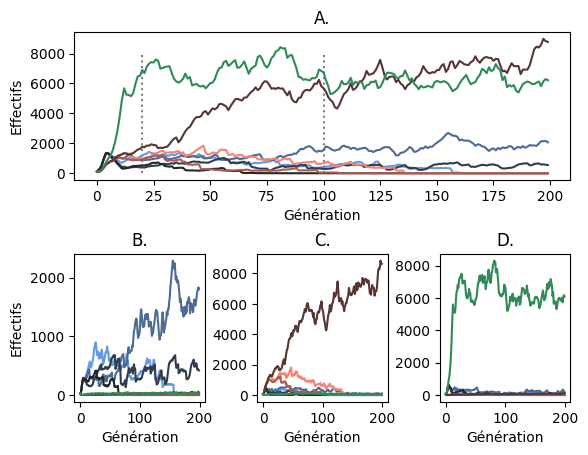

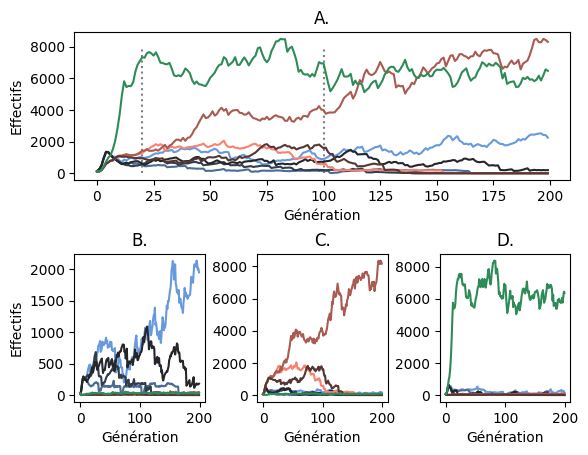

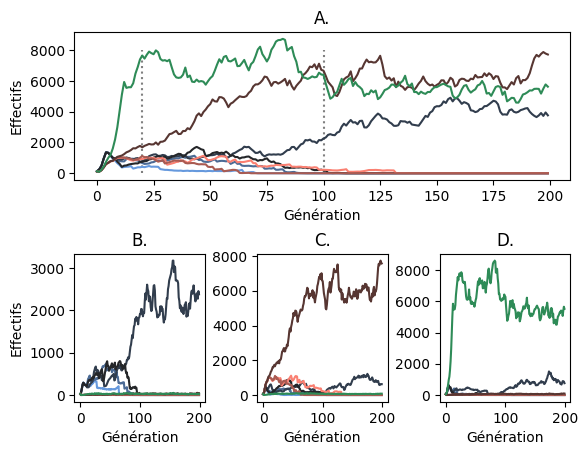

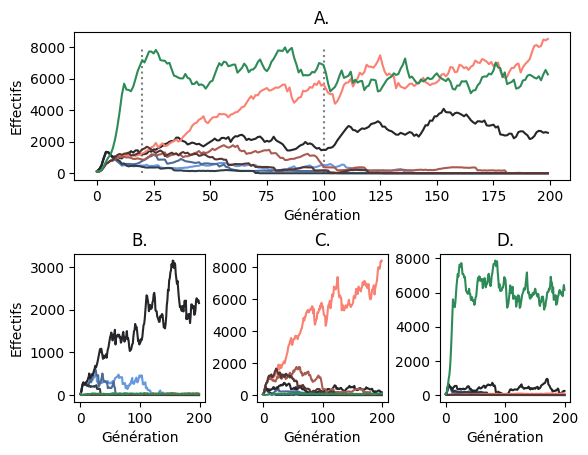

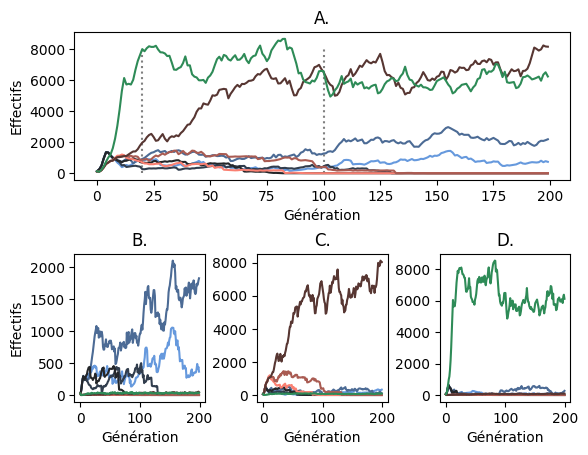

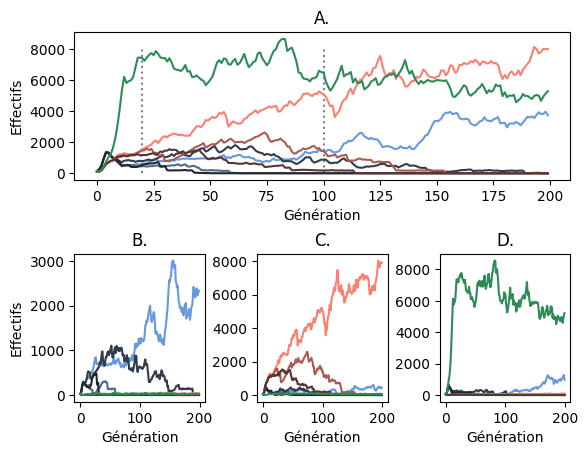

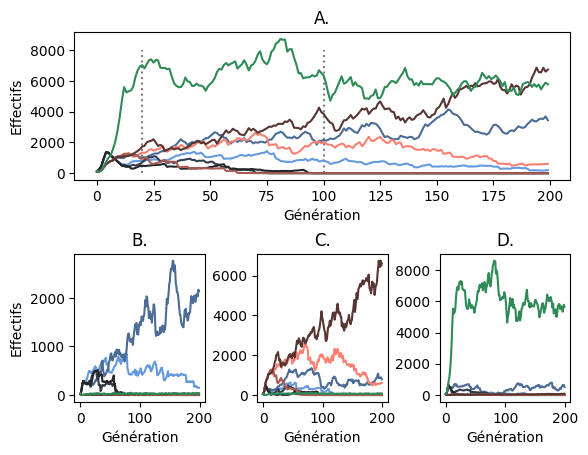

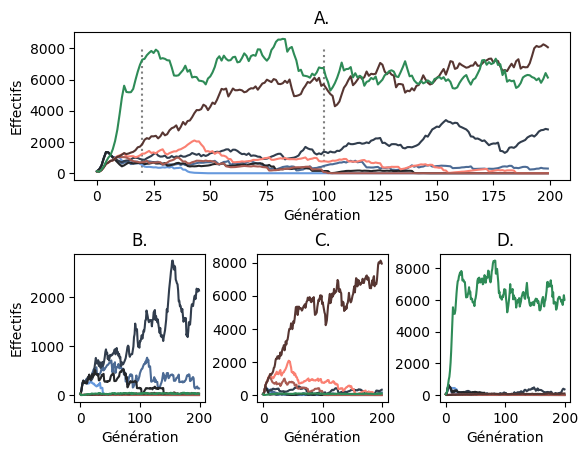

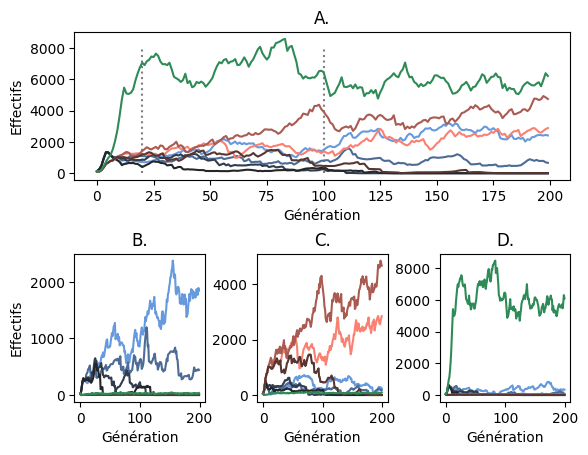

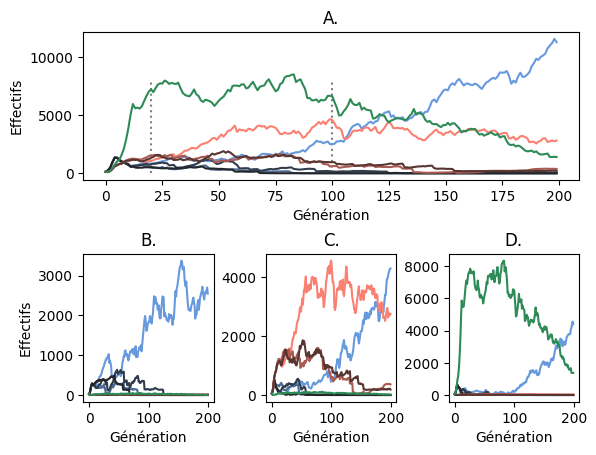

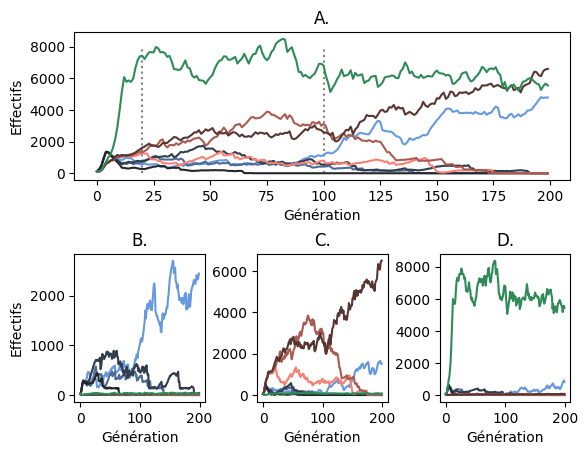

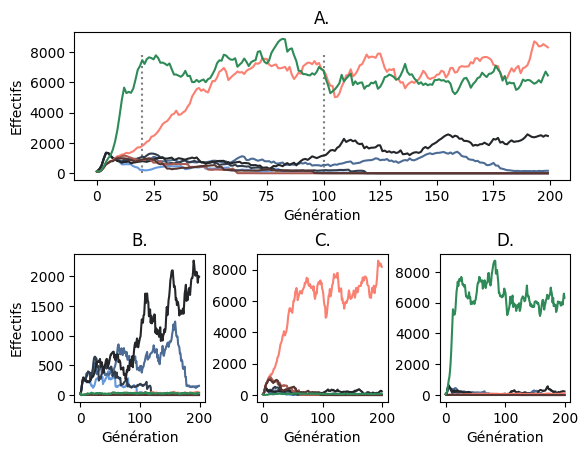

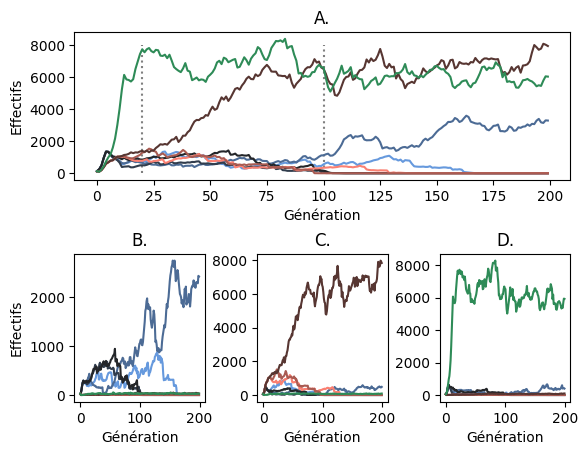

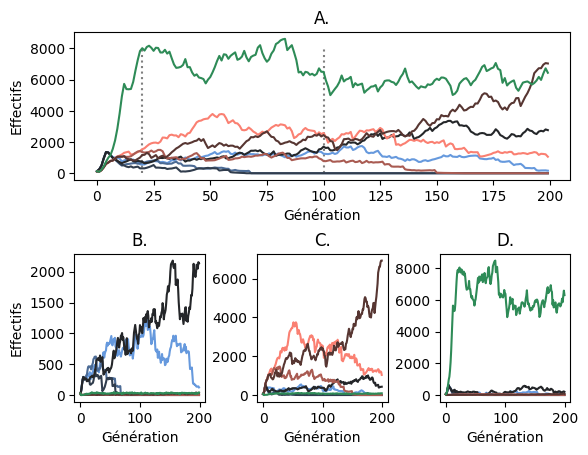

In [84]:
palette = pal_fin
plan = 1
for it in range(NITER):
    AX = gridspec.GridSpec(2,3)
    AX.update(wspace = 0.4, hspace = 0.5)
    ax1  = plt.subplot(AX[0,:])
    ax2 = plt.subplot(AX[1,0])
    ax3 = plt.subplot(AX[1,1])
    ax4 = plt.subplot(AX[1,2])

    ax1.set_xlabel("Génération")
    ax2.set_xlabel("Génération")
    ax3.set_xlabel("Génération")
    ax4.set_xlabel("Génération")
    ax1.set_ylabel("Effectifs")
    ax2.set_ylabel("Effectifs")
    ax1.set_title("A.")
    ax2.set_title("B.")
    ax3.set_title("C.")
    ax4.set_title("D.")
#fig1.set_size_inches(10,10)
    ax1.plot([20,20],[0,8000], 'grey', linestyle = "dotted")
    ax1.plot([100,100],[0,8000], 'grey', linestyle = "dotted")
    for i in range(E):
        ax1.plot(np.sum(results[0][plan][it],axis=1).T[i], color = palette[i])

        ax2.plot(np.sum(res1[0][plan][it],axis=1).T[i], color = palette[i])

        ax3.plot(np.sum(res2[0][plan][it],axis=1).T[i], color = palette[i])

        ax4.plot(np.sum(res3[0][plan][it],axis=1).T[i], color = palette[i])

    plt.show()